# Magnetic Poles
## drift between 2000-01-01 and 2030-01-01

The calucation uses the Fortran libraty of Emmert et al.[1] and wrapped by the [apexpy](https://apexpy.readthedocs.io/en/latest/readme.html) Python package.

This version also calculates the azimut angle of the prime magnetic meridian at the poles locations.

[1] Emmert, J. T., A. D. Richmond, and D. P. Drob (2010),
       A computationally compact representation of Magnetic-Apex
       and Quasi-Dipole coordinates with smooth base vectors,
       J. Geophys. Res., 115(A8), A08322,
       [doi:10.1029/2010JA015326](http://dx.doi.org/10.1029/2010JA015326)

In [1]:
from apexpy import Apex

def qd2geo(time, qdlat, qdlon, height=0, precision=1e-5):
    """ Get geographic coordinates for the given QD coordinates. """
    apex = Apex(time)
    lat, lon, error = apex.qd2geo(qdlat, qdlon, height, precision)
    if error > precision:
        raise RuntimeError(
            "The result precision %gdeg is not within the required limit %gdeg!"
            "" % (error, precision)
        )
    return lat, lon

In [2]:
from datetime import datetime
from itertools import product

start_year = 2000
end_year = 2030

times = [datetime(year, 1, 1) for year in range(start_year, end_year + 1)]

eps = 1 # deg

pole_north = [qd2geo(time, 90, 0) for time in times]
pole_south = [qd2geo(time, -90, 0) for time in times]
pole_north_ngh = [qd2geo(time, 90 - eps, 180) for time in times]
pole_south_ngh = [qd2geo(time, -90 + eps, 0) for time in times]

prime_meridian = [
    qd2geo(times[len(times)//2], lat , 0)  
    for lat in range(-89, 90)
]

anti_meridian = [
    qd2geo(times[len(times)//2], lat , 180)  
    for lat in range(-89, 90)
]

In [3]:
from math import pi
from numpy import array, dot, arccos, sqrt, tan, cross, arctan2
from eoxmagmod import vnorm, convert,GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN

def get_tanget_vector(cart0, cart1):
    """ Get tangent vector at cart0 pointing to cart1.
    cart0 and cart1 are Cartesian coordinates of two distinct points
    on shell of a unit Sphere.
    """
    angle = arccos(dot(cart0, cart1))
    cart1_tan = cart1 * sqrt(1.0 + tan(angle)**2)
    d_cart = cart1_tan - cart0
    return d_cart / vnorm(d_cart)


def calculate_azimuth(coord0, coord1):
    """ Calculate local azimuth at coord0 pointing to coord1.
    coords0 and coord1 are Spherical (lat/lon) coordinates of two
    distinct points on a Sphere.
    """
    lat0, lon0 = coord0
    lat1, lon1 = coord1
    lat2, lon2 = lat0 + 0.1, lon0 # north
    if lat2 > 90:
        lat2 = 180 - lat2, lon2 + 180
        print(lat2, lon2)
    cart0, cart1, cart2 = convert(
        [(lat0, lon0, 1.0), (lat1, lon1, 1.0), (lat0 + 0.1, lon0, 1.0)],
        GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
    )
    cart_dir = get_tanget_vector(cart0, cart1)
    cart_north = get_tanget_vector(cart0, cart2)
    cart_east = cross(cart_north, cart0)
    return arctan2(dot(cart_dir, cart_east), dot(cart_dir, cart_north)) * 180 / pi


azimuth_north = [
    calculate_azimuth(np, npm) for np, npm in zip(pole_north, pole_north_ngh)
]

azimuth_south = [
    calculate_azimuth(sp, spm) for sp, spm in zip(pole_south, pole_south_ngh)
]

In [4]:
from pandas import DataFrame
DataFrame(
    [
        (t, nmp[0], nmp[1], azmn, smp[0], smp[1], azms)
        for t, nmp, smp, azmn, azms in zip(times, pole_north, pole_south, azimuth_north, azimuth_south)
    ],
    columns = [
        "date",
        "northMagPoleLat",
        "northMagPoleLon",
        "northPrimeMeridAzimuth",
        "southMagPoleLat",
        "southPoleLon",
        "southPrimeMeridAzimuth"
    ]
)

,date,northMagPoleLat,northMagPoleLon,northPrimeMeridAzimuth,southMagPoleLat,southPoleLon,southPrimeMeridAzimuth
0,2000-01-01,81.866020,-82.987709,-8.001296,-74.128334,126.434753,160.460766
1,2001-01-01,81.938301,-83.054321,-8.021357,-74.138107,126.396301,160.447508
2,2002-01-01,82.010452,-83.121162,-8.041747,-74.147903,126.357841,160.433509
3,2003-01-01,82.082474,-83.188232,-8.062271,-74.157692,126.319382,160.420156
4,2004-01-01,82.154373,-83.255516,-8.083352,-74.167488,126.280930,160.406628
5,2005-01-01,82.226151,-83.323059,-8.104661,-74.177299,126.242462,160.392930
6,2006-01-01,82.306572,-83.440826,-8.147176,-74.198517,126.196213,160.364156
7,2007-01-01,82.386887,-83.559349,-8.190690,-74.219749,126.150002,160.335197
8,2008-01-01,82.467102,-83.678673,-8.235127,-74.241013,126.103851,160.306180
9,2009-01-01,82.547211,-83.798813,-8.280491,-74.262299,126.057755,160.277201


In [5]:
from matplotlib import pyplot as plt
#from cartopy import crs
from mpl_toolkits.basemap import Basemap
from numpy import arange, asarray

lats_nmp = asarray([v for v, _ in pole_north])
lons_nmp = asarray([v for _, v in pole_north])
lats_smp = asarray([v for v, _ in pole_south])
lons_smp = asarray([v for _, v in pole_south])

lats_mer0_north = asarray([lat for lat, lon in prime_meridian if lat > 0])
lons_mer0_north = asarray([lon for lat, lon in prime_meridian if lat > 0])
lats_mer0_south = asarray([lat for lat, lon in prime_meridian if lat < 0])
lons_mer0_south = asarray([lon for lat, lon in prime_meridian if lat < 0])
lats_mer1_north = asarray([lat for lat, lon in anti_meridian if lat > 0])
lons_mer1_north = asarray([lon for lat, lon in anti_meridian if lat > 0])
lats_mer1_south = asarray([lat for lat, lon in anti_meridian if lat < 0])
lons_mer1_south = asarray([lon for lat, lon in anti_meridian if lat < 0])

/home/pacesm/virtenv_python27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


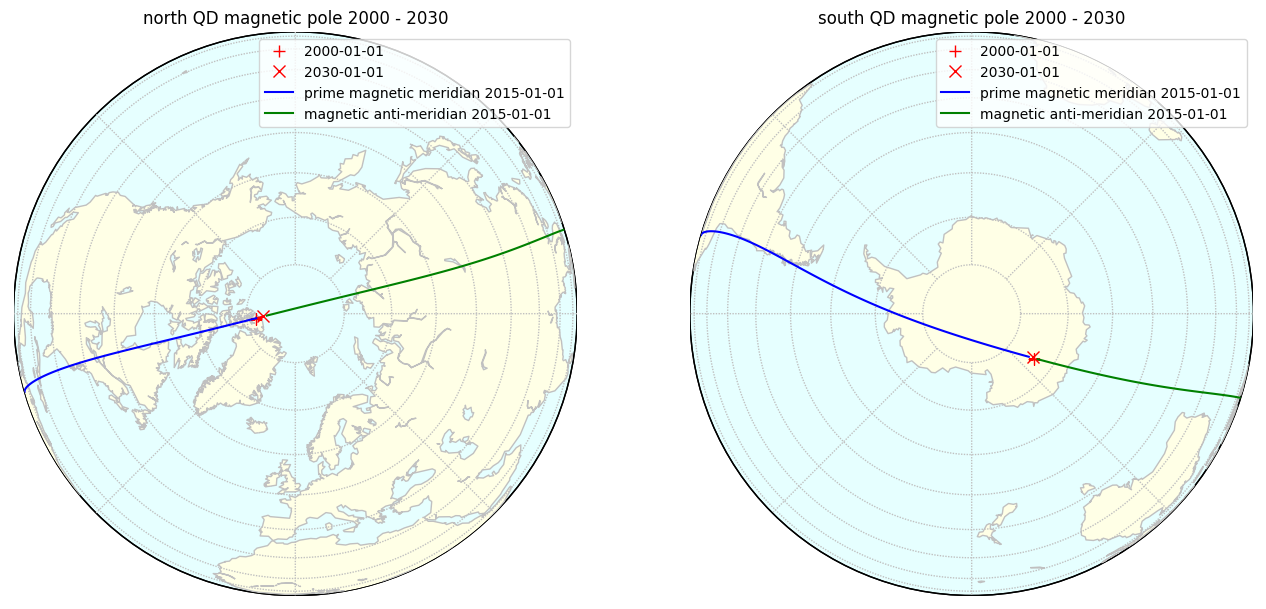

In [6]:
fig=plt.figure(figsize=(16, 16), dpi= 100, facecolor='w', edgecolor='k')

plt.subplot(121)
plt.title("north QD magnetic pole 2000 - 2030")
map = Basemap(projection='ortho', lon_0=0, lat_0=90)
map.drawcoastlines(color="silver")
map.fillcontinents(color=(1.0, 1.0, 0.9), lake_color=(0.9, 1.0, 1.0))
map.drawmapboundary(fill_color=(0.9, 1.0, 1.0))
map.drawmeridians([-135, -90, -45, 0, 45, 90, 135, 180], color="silver")
map.drawparallels([10, 20, 30, 40, 50, 60, 70], color="silver")
map.plot(lons_nmp, lats_nmp, 'r-', latlon=True)
h1, = map.plot(lons_nmp[0], lats_nmp[0], 'r+', latlon=True, markersize=8)
h2, = map.plot(lons_nmp[-1], lats_nmp[-1], 'rx', latlon=True, markersize=8)
h3, = map.plot(lons_mer0_north, lats_mer0_north, 'b-', latlon=True)
h4, = map.plot(lons_mer1_north, lats_mer1_north, 'g-', latlon=True)
plt.legend(
    (h1, h2, h3, h4), (
        times[0].date(),
        times[-1].date(),
        "prime magnetic meridian %s" % times[len(times)/2].date(),
        "magnetic anti-meridian %s" % times[len(times)/2].date(),
    ), loc=1
)

plt.subplot(122)
plt.title("south QD magnetic pole 2000 - 2030")
map = Basemap(projection='ortho', lon_0=0, lat_0=-90)
map.drawcoastlines(color="silver")
map.fillcontinents(color=(1.0, 1.0, 0.9), lake_color=(0.9, 1.0, 1.0))
map.drawmapboundary(fill_color=(0.9, 1.0, 1.0))
map.drawmeridians([-135, -90, -45, 0, 45, 90, 135, 180], color="silver")
map.drawparallels([-70, -60, -50, -40, -30, -20, -10], color="silver")
map.plot(lons_smp, lats_smp, 'r-', latlon=True)
h1, = map.plot(lons_smp[0], lats_smp[0], 'r+', latlon=True, markersize=8)
h2, = map.plot(lons_smp[-1], lats_smp[-1], 'rx', latlon=True, markersize=8)
h3, = map.plot(lons_mer0_south, lats_mer0_south, 'b-', latlon=True)
h4, = map.plot(lons_mer1_south, lats_mer1_south, 'g-', latlon=True)

plt.legend(
    (h1, h2, h3, h4), (
        times[0].date(),
        times[-1].date(),
        "prime magnetic meridian %s" % times[len(times)//2].date(),
        "magnetic anti-meridian %s" % times[len(times)//2].date(),
    ), loc=1
)

plt.show()